# Analysis of SARS-Cov-2 intrasample variation

You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

In [1]:
# Set display to the full length

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 599kB/s ta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1


In [3]:
!pip install --upgrade seaborn

     |████████████████████████████████| 216 kB 4.5 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [4]:
# install pandasql
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=28405 sha256=8616c787ab74ea2463213a9b3024ee4b9c889814445d5c837b15ebf5654b9145
  Stored in directory: /home/jovyan/.cache/pip/wheels/33/dc/52/fcd9f8b4528e668922f2b776e423db0a07bdd973ea02ffd2ef
Successfully built pandasql


In [5]:
import pandas as pd
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
%matplotlib inline

This notebook imports two datasets from Galaxy history:

 - a table of variants 
 - a GenBank file for NC_045512

In [6]:
# Import two datasets
# The number inside `get()` function corresponds to history ID

var_file = 6     # Number of history item with variant list
gb_file = 3      # Number of histoiry item containing genbank annoration for NC_045512

var_path = get(var_file)
gb_path = get(gb_file)

In [7]:
# Clean artifacts of SNPeff from file headers

!cat {var_path} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab

In [8]:
# Create dataframes

var  = pd.read_csv('var.tab', sep='\t')

In [9]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON
0,SRR11177792,NC_045512,58,T,C,2983,0.016091,3,"2225,704,39,9",.,.,.,.,.
1,SRR11177792,NC_045512,60,T,C,3057,0.010795,4,"2295,722,25,11",.,.,.,.,.
2,SRR11177792,NC_045512,61,G,A,3296,0.006978,2,"2496,774,19,4",.,.,.,.,.
3,SRR11177792,NC_045512,63,T,C,3476,0.019563,1,"2589,814,53,18",.,.,.,.,.
4,SRR11177792,NC_045512,65,T,C,3742,0.015767,1,"2807,874,44,16",.,.,.,.,.


In [10]:
# Add fiels describing viant type and set it to "I" (indels) for those rows that reference or alternative are gaps (-)
# or are of unequial length

var.loc[ ( var['REF'] == '-' ) | ( var['ALT'] == '-' ) ,'type'] = 'I'
var.loc[ ( var['ALT'].str.len() != var['REF'].str.len() ), 'type' ] = 'I'

In [11]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR11177792,NC_045512,58,T,C,2983,0.016091,3,"2225,704,39,9",.,.,.,.,.,NaN
1,SRR11177792,NC_045512,60,T,C,3057,0.010795,4,"2295,722,25,11",.,.,.,.,.,NaN
2,SRR11177792,NC_045512,61,G,A,3296,0.006978,2,"2496,774,19,4",.,.,.,.,.,NaN
3,SRR11177792,NC_045512,63,T,C,3476,0.019563,1,"2589,814,53,18",.,.,.,.,.,NaN
4,SRR11177792,NC_045512,65,T,C,3742,0.015767,1,"2807,874,44,16",.,.,.,.,.,NaN


In [12]:
# Set type field for SNPs
var.loc[ ( var['REF'].str.len() == 1 ) & ( var['ALT'].str.len() == 1 ) & (var['type'].isnull()), 'type'] = 'S'

In [13]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR11177792,NC_045512,58,T,C,2983,0.016091,3,"2225,704,39,9",.,.,.,.,.,S
1,SRR11177792,NC_045512,60,T,C,3057,0.010795,4,"2295,722,25,11",.,.,.,.,.,S
2,SRR11177792,NC_045512,61,G,A,3296,0.006978,2,"2496,774,19,4",.,.,.,.,.,S
3,SRR11177792,NC_045512,63,T,C,3476,0.019563,1,"2589,814,53,18",.,.,.,.,.,S
4,SRR11177792,NC_045512,65,T,C,3742,0.015767,1,"2807,874,44,16",.,.,.,.,.,S


In [14]:
# Set type field for MNPs 
var.loc[ ( ( var['REF'].str.len() > 1 ) & ( var['ALT'].str.len() == var['REF'].str.len() ) ) , 'type'  ] = 'M'

In [15]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR11177792,NC_045512,58,T,C,2983,0.016091,3,"2225,704,39,9",.,.,.,.,.,S
1,SRR11177792,NC_045512,60,T,C,3057,0.010795,4,"2295,722,25,11",.,.,.,.,.,S
2,SRR11177792,NC_045512,61,G,A,3296,0.006978,2,"2496,774,19,4",.,.,.,.,.,S
3,SRR11177792,NC_045512,63,T,C,3476,0.019563,1,"2589,814,53,18",.,.,.,.,.,S
4,SRR11177792,NC_045512,65,T,C,3742,0.015767,1,"2807,874,44,16",.,.,.,.,.,S


In [16]:
# Select counts by Sample and by type

pysqldf('select Sample, type, count(*) from var group by Sample, type')

,Sample,type,count(*)
0,SRR10903401.fastq,S,70
1,SRR10903402.fastq,S,215
2,SRR10971381.fastq,S,96
3,SRR11140744,S,2875
4,SRR11140746,S,2070
5,SRR11140748,S,2448
6,SRR11140750,S,118
7,SRR11177792,S,24743
8,SRR11241254,S,10
9,SRR11241255,S,17


In [17]:
# Select counts by Sample and by type for SNPs wil allele frequency above 5%

pysqldf('select Sample, type, count(*) from var where AF >= 0.05 group by Sample, type')

,Sample,type,count(*)
0,SRR10903401.fastq,S,9
1,SRR10903402.fastq,S,6
2,SRR10971381.fastq,S,14
3,SRR11140744,S,4
4,SRR11140746,S,2
5,SRR11140748,S,3
6,SRR11140750,S,12
7,SRR11177792,S,6
8,SRR11241254,S,2
9,SRR11241255,S,8


In [18]:
pysqldf('select Sample, EFFECT, count(*) as N from var group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0)

EFFECT,.,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING+SPLICE_SITE_REGION,SPLICE_SITE_REGION+SYNONYMOUS_CODING,SPLICE_SITE_REGION+SYNONYMOUS_STOP,START_LOST,STOP_GAINED,STOP_LOST,STOP_LOST+SPLICE_SITE_REGION,SYNONYMOUS_CODING,SYNONYMOUS_STOP
Sample,,,,,,,,,,,
SRR10903401.fastq,0.0,43.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,23.0,0.0
SRR10903402.fastq,4.0,138.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,69.0,0.0
SRR10971381.fastq,3.0,46.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,43.0,0.0
SRR11140744,18.0,1678.0,0.0,0.0,0.0,2.0,19.0,0.0,0.0,1158.0,0.0
SRR11140746,15.0,1210.0,0.0,0.0,0.0,1.0,14.0,0.0,0.0,830.0,0.0
SRR11140748,27.0,1425.0,0.0,0.0,0.0,2.0,17.0,0.0,0.0,977.0,0.0
SRR11140750,2.0,74.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,41.0,0.0
SRR11177792,289.0,15366.0,2.0,1.0,19.0,26.0,373.0,1.0,15.0,8649.0,2.0
SRR11241254,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [19]:
pysqldf('select Sample, EFFECT, count(*) as N from var where AF >= 0.05 group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0)

EFFECT,.,NON_SYNONYMOUS_CODING,START_LOST,STOP_GAINED,SYNONYMOUS_CODING
Sample,,,,,
SRR10903401.fastq,0.0,4.0,0.0,1.0,4.0
SRR10903402.fastq,1.0,4.0,0.0,0.0,1.0
SRR10971381.fastq,0.0,6.0,1.0,0.0,7.0
SRR11140744,0.0,1.0,0.0,0.0,3.0
SRR11140746,0.0,0.0,0.0,0.0,2.0
SRR11140748,0.0,1.0,0.0,0.0,2.0
SRR11140750,0.0,7.0,0.0,0.0,5.0
SRR11177792,0.0,4.0,0.0,0.0,2.0
SRR11241254,0.0,1.0,0.0,0.0,1.0


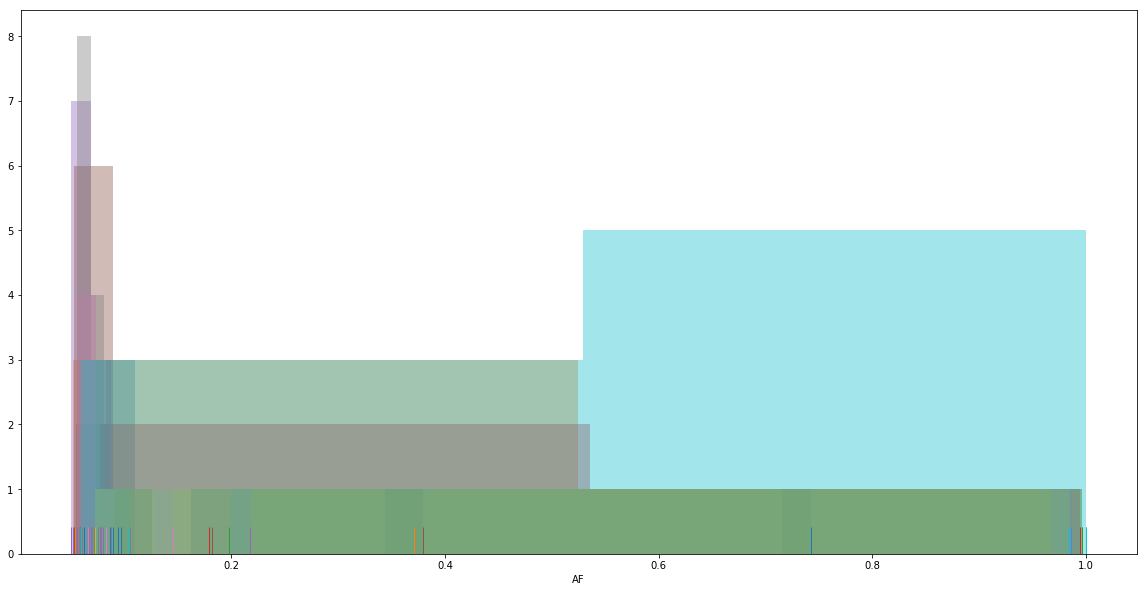

In [20]:
# Plot histogram of allele frequencies for three sample
# Restricted to variants with minor allele frequency above 5%

plt.figure(figsize=(20,10))
for sample in var['Sample'].unique():
    sns.distplot(var['AF'][(var['AF']>=0.05) & (var['Sample']==sample)],kde=False,rug=True)

In [21]:
# Define categorical columns

for col in ['IMPACT','FUNCLASS','EFFECT']:
    var[col] = var[col].astype('category')

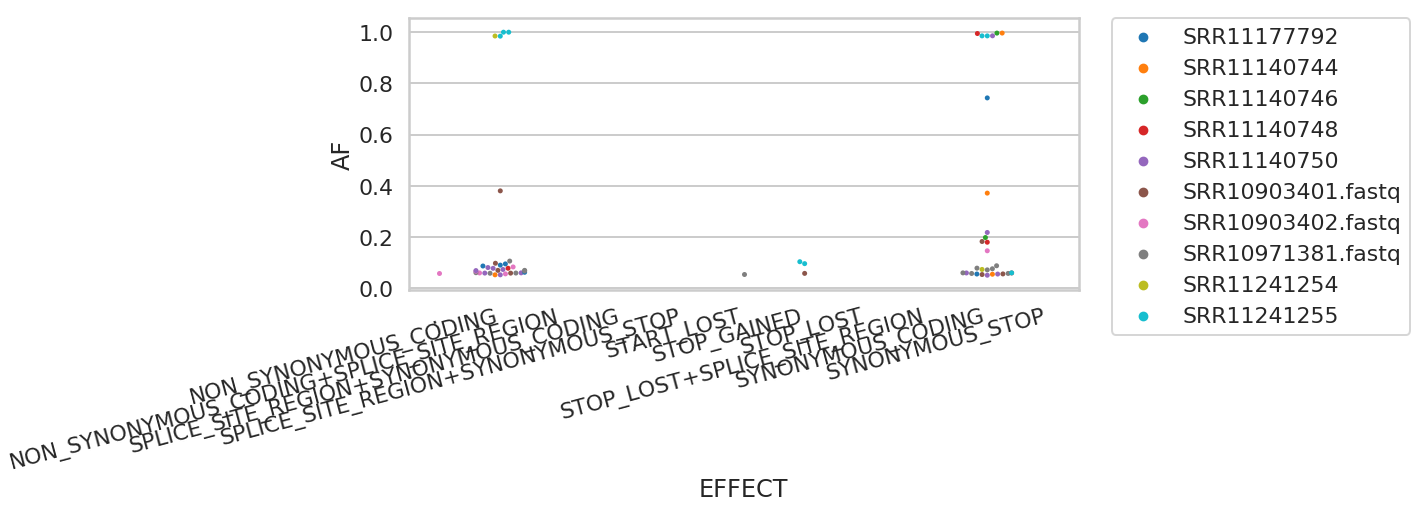

In [33]:
# Plot Allele frequences by samples and functional categories

plt.figure(figsize=(12,5))
g = sns.swarmplot(x='EFFECT',y='AF',data=var[var['AF']>=0.05], hue='Sample')
g.set_xticklabels(g.get_xticklabels(), rotation=15, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [25]:
# Read GenBank file with annotations for NC_045512
from Bio import SeqIO
record = SeqIO.read(gb_path,'genbank')

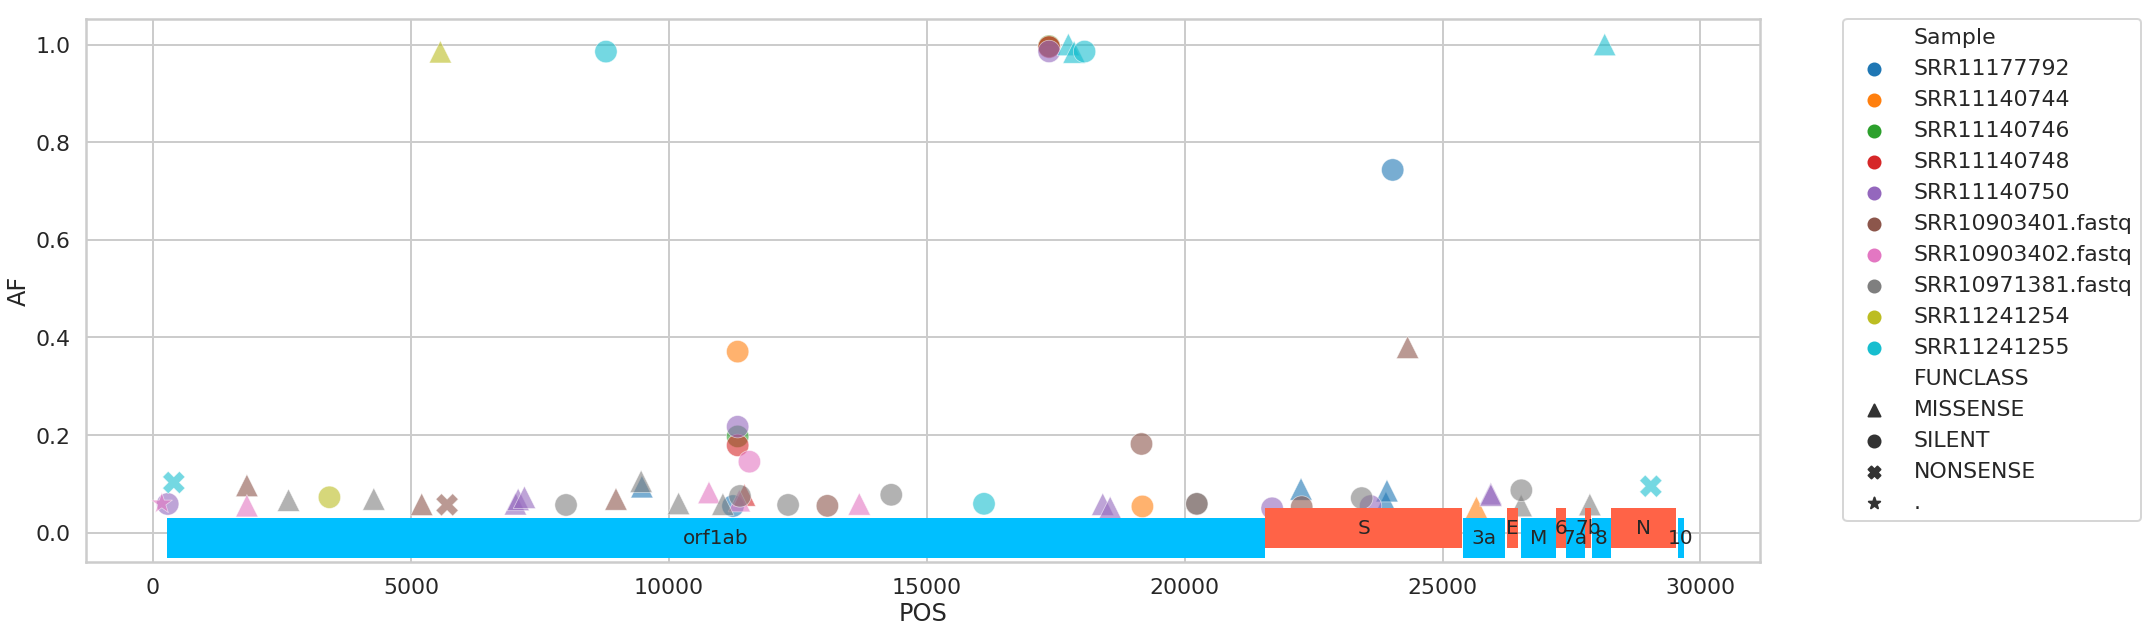

In [31]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set_context("poster")
sns.set_style("whitegrid")
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o"}
sns.scatterplot(x='POS',y='AF',data=var[var['AF']>=0.05],hue='Sample',style='FUNCLASS',legend='brief',alpha=0.6,s=500,markers=markers)
i = 0
for feature in record.features:
    if feature.type == 'gene':
        i += 1
        gene_name = feature.qualifiers['gene'][0]
        if gene_name.startswith('ORF'):
            gene_name=gene_name[3:]
        if i % 2 == 0:
            color ='tomato'
            y = 0.01
        else:
            color ='deepskyblue'
            y = -0.01
        plt.hlines(y,feature.location._start.position, feature.location._end.position, linewidth=40,color=color)
        plt.text(feature.location._start.position+(feature.location._end.position-feature.location._start.position)//2, y, gene_name,horizontalalignment='center',verticalalignment='center',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [30]:
# List varinats by Sample and by position highlighting allel frequencies

var[var['AF']>0.05].sort_values(by=['AF','POS'],ascending=False).style.bar(subset=['AF'],color='#d65f5f')